In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import re
import csv
import pymorphy2
import datetime
from sqlalchemy import create_engine
from sqlalchemy.pool import NullPool
import logging
import sys

In [ ]:
csv.field_size_limit(int(sys.maxsize/10000000000));

Т.к. датасет большой, то буду загружать данные порциями, очищать, нормализовать и генерировать новые фичи.
Подготовленные данные запишу в базу данных и буду работать с ней.

Все необходимые функции:

In [3]:
def CleanDataFirstSatge (df):
    '''
    Удалю статьи, состоящие только из одного слова/символа или цифр.
    Так же статьи с пустым полем 'text'
    '''
    df_for_drop = df[((df['text'].apply(lambda t: len(t.strip().split()))<=1)\
      & (df['tittle'].apply(lambda t: len(t.strip().split()))<=1))\
      | (df['text'] == '   ')]
    return df_for_drop.index

In [4]:
def AddNewFeature_dates(df):
    '''
    Генерация фич на основе времени
    '''
    df['date'] = pd.to_datetime(df['date'])
    df['month'] = df['date'].dt.month 
    df['day'] = df['date'].dt.day 
    df['hour'] = df['date'].dt.hour 
    df['weekday'] = df['date'].dt.dayofweek
    #df.sort_values(by='date',ascending=True,inplace=True)
    
    return df['date'],df['month'],df['day'],df['hour'],df['weekday']

In [5]:
def GetSites (txt):  
    sites = re.findall(r'[\w]+\.{1,1}[^\.\d^\s]\w{1,3}\b',str(txt)) #сайты
    return (' '.join(sites)).replace('.','_'),len(sites)

In [6]:
def GetEnWords (txt):  
    en_words = re.findall(r'\b[A-Za-z]{3,}\b',re.sub(r'[A-Za-z]{2,}\.+[A-Za-z]*\b','',str(txt))) #слова на латинице от 3х букв    
    return ' '.join(en_words),len(en_words)

In [7]:
def GetRuWords (txt):  
    ru_words = re.findall(r'\b[А-Яа-я]{4,}\b',re.sub(r'[А-Яа-я]{2,}\.+[А-Яа-я]*\b','',str(txt))) #слова на кириллице от 4х букв
    return ' '.join(ru_words),len(ru_words)

In [8]:
def GetPunctuationsCount (txt):  
    punctuations  = re.findall(r'[^\w\s]',txt) #Знаки препинания
    return len(punctuations)

In [9]:
def GetEmotionsCount (txt):  
    emotions  = re.findall(r'[\?]{2,}|[\!]{2,}',txt) #Знаки ??? , !!!
    return len(emotions)

In [10]:
def GetAllWordsCount (txt):  
    words_count = len(txt.strip().split()) #Количество текстовых объектов
    clwords  = re.findall(r'[А-ЯA-Z]{1,}[а-яa-z]{1,}\b',txt) #Количество слов с заглавной буквы
    return words_count,len(clwords)

In [11]:
def AddNewFeatures_from_txt(columns):
    for index, row in df.iterrows():
        df.loc[index, 'sites_'+column],df.loc[index, 'sites_'+column+'_count'] = GetSites(row[column])
        df.loc[index, 'ru_words_'+column],df.loc[index, 'ru_words_'+column+'_count'] = GetRuWords(row[column])
        df.loc[index, 'en_words_'+column],df.loc[index, 'en_words_'+column+'_count'] = GetEnWords(row[column])
        df.loc[index, 'punctuations_'+column+'_count'] = GetPunctuationsCount(row[column])
        df.loc[index, 'emotions_'+column+'_count'] = GetEmotionsCount(row[column])
        df.loc[index, column+'_words_count'],df.loc[index, column+'_clwords_count']

In [12]:
def AddNewFeature_text_category(df):
    '''
    Создание фичи категория текста (размер)
    '''
    twc25 = df['text_words_count'].describe()['25%']
    twc50 = df['text_words_count'].describe()['50%']
    twc75 = df['text_words_count'].describe()['75%']
    twcmax = df['text_words_count'].describe()['max']
    
    df['text_category'] = pd.cut(df.text_words_count\
                             ,bins=[-1,0,twc25,twc50,twc75,twcmax]\
                             ,labels=['0','1','2','3','4']) 
    return df['text_category']

In [13]:
def AddNewFeature_rate_category (df):
    #Разделю рейтинги на 3 категории (отрицательный, нейтральный и положительный)
    df_rate_count = df['rate'].value_counts().rename('count').reset_index()
    df_rate_count.rename({'index':'rate'}, axis='columns',inplace=True)
    df['rate_category'] = pd.cut(df.rate,bins=[df_rate_count['rate'].min()-1,-1,0,\
                                           df_rate_count['rate'].max()+1],labels=[-1,0,1])
    return df['rate_category']

In [14]:
def StrLower (series):
    #Перевод в нижний регистр
    col = series.str.lower()
    return col

In [15]:
def f_tokenizer(s):
    '''
    Нормализация текста
    '''
    morph = pymorphy2.MorphAnalyzer()    
    if type(s) == str:
        t = s.split(' ')
    else:
        t = s
    f = []
    for j in t:
        m = morph.parse(j.replace('.',''))
        if len(m) != 0:
            wrd = m[0]
            if wrd.tag.POS not in ('NUMR','PREP','CONJ','PRCL','INTJ'):
                f.append(wrd.normal_form)
    return ' '.join(f)

In [16]:
def AddNewFeature_norm(df):
    df['ru_words_text']=df['ru_words_text'].apply(lambda t: f_tokenizer(t))
    return df['ru_words_text']

Конвеер обработки данных:

In [17]:
csv_db = create_engine('sqlite:///dataset/csv_db.db', poolclass=NullPool) #Соединение с БД

### !!! Работает долго, запускать только 1 раз для экспорта данных в БД

In [51]:
text_column = 'text'
tittle_column = 'tittle'
parts_text_columns = ['sites_text', 'ru_words_text','en_words_text']

In [52]:
#Добавлю логирование
LOG_FILENAME = 'export_to_db.log'
logging.basicConfig(filename='dataset/'+LOG_FILENAME,\
                    level=logging.ERROR,\
                    format='%(asctime)s: %(message)s',\
                    datefmt='%Y-%m-%d %H-%M-%S')
logger = logging.getLogger('db')
logger.setLevel(logging.INFO)


#Подготавливаем данные и пишем в БД
start = 193001 #Если нужно начать/продолжить с определенной строки, например с 60001
chunksize = 1000 #Сколько строк брать за раз

iteration=1
for df in pd.read_csv('dataset/clear_dataset.csv', chunksize=chunksize, iterator=True,sep=',',\
                        encoding='utf-8', engine="python", error_bad_lines=False):
    df.index +=1
    
    if df.index[-1] <start:
         pass
    else:
        logger.info('Итерация [{}]'.format(iteration))
        logger.info('   Очистка от пустых данных')
        df.drop(CleanDataFirstSatge(df),inplace=True)  
    
        logger.info('   Геренерация фич на основе времени')
        df['date'],df['month'],df['day'],df['hour'],df['weekday'] = AddNewFeature_dates(df)  
    
        logger.info('   Генерация числовых и категориальных фич на основе текста')
        for index, row in df.iterrows():
            df.loc[index, 'sites_'+text_column],df.loc[index, 'sites_'+text_column+'_count'] = GetSites(row[text_column])
            df.loc[index, 'ru_words_'+text_column],df.loc[index, 'ru_words_'+text_column+'_count'] = GetRuWords(row[text_column])
            df.loc[index, 'en_words_'+text_column],df.loc[index, 'en_words_'+text_column+'_count'] = GetEnWords(row[text_column])
            df.loc[index, 'punctuations_'+text_column+'_count'] = GetPunctuationsCount(row[text_column])
            df.loc[index, 'emotions_'+text_column+'_count'] = GetEmotionsCount(row[text_column])
            df.loc[index, text_column+'_words_count'],df.loc[index, text_column+'_clwords_count'] = GetAllWordsCount(row[text_column])
            df.loc[index, tittle_column+'_words_count'],df.loc[index, tittle_column+'_clwords_count'] = GetAllWordsCount(row[tittle_column])
    
        logger.info('   Удаление статей без текста')
        df.drop(df[df['text_words_count']==0].index,inplace=True)
    
        logger.info('   Фича категория рейтинга')
        df['rate_category'] = AddNewFeature_rate_category(df)
        
        logger.info('   Перевод текста в нижний регистр')
        for col in parts_text_columns:
            df[col] = StrLower(df[col])
    
        logger.info('   Нормализация текста')
        df['ru_words_text'] = AddNewFeature_norm(df)    
    
        logger.info('   Запись в БД')
        df.to_sql('habr', csv_db, if_exists='append')
    
        logger.info('   Всего обработано строк [{}]'.format(iteration*chunksize))
    iteration+=1

In [53]:
logging.shutdown() #Убираю логирование

In [78]:
# Remove all handlers associated with the root logger object.
#for handler in logging.root.handlers[:]:
#    logging.root.removeHandler(handler)

В итоге обработка заняла ~12.5 часов. В БД находятся все статьи, оригинальные столбцы + новые, сгенерированные фичи, так же нормализованный текст из столбца text.

Описание столбцов:
Оригинальные:
1. date - дата и время публикации статьи
2. tittle - заголовок статьи
3. text - текст статьи
4. rate - рейтинг статьи
Сгенерированные фичи:
1. month - месяц публикации статьи
2. day - число публикации статьи
3. hour - час публикации статьи
4. weekday - день недели публикации статьи (0-п,6-вс)
5. sites_text - сайты, извлеченные из столбца text в формате "cnews_ru"
6. sites_text_count - количество сайтов в столбце text
7. ru_words_text - нормализованные слова на кириллице, извлеченные из text
8. ru_words_text_count - количество слов в text (до нормализации)
9. en_words_text - слова на латинице, извлеченные из text
10. en_words_text_count - количество слов на латинице
11. punctuations_text_count - количество пунктуаций в text
12. emotions_text_count - количество знаков эмоций в text(!!!,???)
13. text_words_count - количество всех текстовых объектов из text разделенных пробелом
14. text_clwords_count - количество всех слов с заглавной буквы в text
15. tittle_words_count - количество всех текстовых объектов из tittle разделенных пробелом
16. tittle_clwords_count - количество всех слов с заглавной буквы в tittle
17. rate_category - категория рейтинга статьи (отриц., нейтральный, положительн.)

Выгружу все числовые данные для анализа

In [248]:
columns_num = str('date,rate,month,day,hour,weekday,\
sites_text_count,ru_words_text_count,en_words_text_count,\
punctuations_text_count,emotions_text_count,text_words_count,\
text_clwords_count,tittle_words_count,tittle_clwords_count,rate_category')

In [249]:
df = pd.read_sql_query("SELECT {} FROM habr".format(columns_num), csv_db)

In [18]:
df = pd.read_sql_query("SELECT * FROM habr", csv_db)

In [20]:
df.drop(['index'],axis=1,inplace=True)

In [21]:
df.isnull().sum()

date                       0
tittle                     0
text                       0
rate                       0
month                      0
day                        0
hour                       0
weekday                    0
sites_text                 0
sites_text_count           0
ru_words_text              0
ru_words_text_count        0
en_words_text              0
en_words_text_count        0
punctuations_text_count    0
emotions_text_count        0
text_words_count           0
text_clwords_count         0
tittle_words_count         0
tittle_clwords_count       0
text_category              0
rate_category              0
dtype: int64

Создам новый столбец - категория текста, на основе квартилей

<font color='green'>#new_feature</font>

In [247]:
df_tc = df[['text_words_count']].describe()
df['text_category'] = pd.cut(df.text_words_count,bins=[-1,0,int(df_tc.loc['25%']),int(df_tc.loc['50%']),\
                                 int(df_tc.loc['75%']),int(df_tc.loc['max'])]\
                                                                 ,labels=['0','1','2','3','4']) 

Приведу данные в нужные типы

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209959 entries, 0 to 209958
Data columns (total 22 columns):
date                       209959 non-null object
tittle                     209959 non-null object
text                       209959 non-null object
rate                       209959 non-null int64
month                      209959 non-null int64
day                        209959 non-null int64
hour                       209959 non-null int64
weekday                    209959 non-null int64
sites_text                 209959 non-null object
sites_text_count           209959 non-null float64
ru_words_text              209959 non-null object
ru_words_text_count        209959 non-null float64
en_words_text              209959 non-null object
en_words_text_count        209959 non-null float64
punctuations_text_count    209959 non-null float64
emotions_text_count        209959 non-null float64
text_words_count           209959 non-null float64
text_clwords_count         209959 non-

<font color='orange'>#change_data</font>

In [24]:
df['date'] = pd.to_datetime(df['date'])

In [25]:
df = df.astype({'rate':'int16', 'month':'uint8', 'day':'uint8',\
                'day':'uint8', 'hour':'uint8', 'weekday':'uint8', \
                'sites_text_count':'uint16',\
                'ru_words_text_count':'uint32',\
                'en_words_text_count':'uint16',\
                'punctuations_text_count':'uint32',\
                'emotions_text_count':'uint16',\
                'punctuations_text_count':'uint32',\
                'text_words_count':'uint32',\
                'text_clwords_count':'uint32',\
                'tittle_words_count':'uint8',\
                'tittle_clwords_count':'uint8',\
                'rate_category':'int8'})

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209959 entries, 0 to 209958
Data columns (total 22 columns):
date                       209959 non-null datetime64[ns]
tittle                     209959 non-null object
text                       209959 non-null object
rate                       209959 non-null int16
month                      209959 non-null uint8
day                        209959 non-null uint8
hour                       209959 non-null uint8
weekday                    209959 non-null uint8
sites_text                 209959 non-null object
sites_text_count           209959 non-null uint16
ru_words_text              209959 non-null object
ru_words_text_count        209959 non-null uint32
en_words_text              209959 non-null object
en_words_text_count        209959 non-null uint16
punctuations_text_count    209959 non-null uint32
emotions_text_count        209959 non-null uint16
text_words_count           209959 non-null uint32
text_clwords_count         209959 no

Посмотрю на дубликаты. Искать буду по одинаковым заголовкам, где совпадает дата публикации и рейтинг.

In [27]:
df[df.duplicated(subset=['date','tittle','rate'],keep=False)].\
                                        sort_values(by='tittle')

,date,tittle,text,rate,month,day,hour,weekday,sites_text,sites_text_count,...,en_words_text,en_words_text_count,punctuations_text_count,emotions_text_count,text_words_count,text_clwords_count,tittle_words_count,tittle_clwords_count,text_category,rate_category
98564,2013-05-08 10:26:00,+1 чёрный список в России,В России есть открыто пополняемый Федеральный...,82,5,8,10,2,,0,...,eve online death note snowflake,5,144,0,560,42,5,1,3,1
137560,2013-05-08 10:26:00,+1 чёрный список в России,В России есть открыто пополняемый Федеральный...,82,5,8,10,2,,0,...,eve online death note snowflake,5,144,0,560,42,5,1,3,1
924,2006-06-28 00:21:00,-2147220992 (0×80040200),В 4 часа утра на первой странице сайта ИТАР-Т...,1,6,28,0,2,,0,...,,0,4,0,19,1,2,0,1,1
138751,2006-06-28 00:21:00,-2147220992 (0×80040200),В 4 часа утра на первой странице сайта ИТАР-Т...,1,6,28,0,2,,0,...,,0,4,0,19,1,2,0,1,1
137571,2013-05-23 16:42:00,"1,7 миллиона долларов суд хочет взыскать с вла...",21 мая суд Днепровского района Киева вынес...,149,5,23,16,3,,0,...,sophia homes riviera riverside upd,5,33,0,174,21,12,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138909,2007-11-21 13:19:00,"Ярушечка, жежешечка и лирушечка",За последние две недели произошло сразу два с...,-1,11,21,13,2,liveinternet_ru я_ру liveinternet_ru я_ру live...,6,...,pdf opml pdf,3,122,0,411,27,4,1,2,-1
51334,2010-05-07 15:22:00,одоп Элюстро,Кто-нибудь рискнет устроиться?,130,5,7,15,4,,0,...,,0,2,0,3,1,2,1,1,1
137912,2010-05-07 15:22:00,одоп Элюстро,Кто-нибудь рискнет устроиться?,130,5,7,15,4,,0,...,,0,2,0,3,1,2,1,1,1
60900,2010-12-09 20:55:00,"﻿Всемирный день футбола — праздник, которого н...","Год назад я писал о Всемирном дне футбола, се...",4,12,9,20,3,,0,...,world football day,3,30,0,151,16,9,2,1,1


Такие статьи нужно оставить в 1 экземпляре, без дублирования

In [28]:
df.drop_duplicates(subset=['date','tittle','rate'],keep='first',\
                                                       inplace=True)

## Анализ данных

Количество статей в зависимости от количества слов в заголовке.

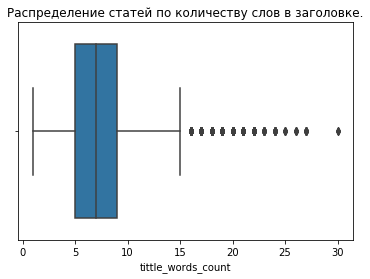

In [109]:
plt.title('Распределение статей по количеству слов в заголовке.')
sns.boxplot(x=df['tittle_words_count']);

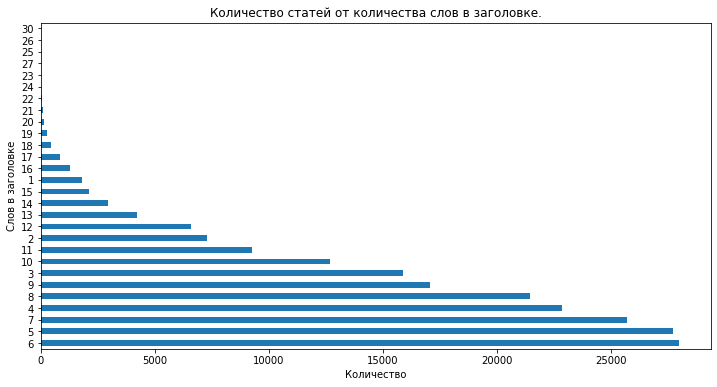

In [113]:
fsize = (12, 6)
fig, ax = plt.subplots(figsize=fsize)
plt.title('Количество статей от количества слов в заголовке.')
plt.xlabel('Количество')
plt.ylabel('Слов в заголовке')
df['tittle_words_count'].value_counts().plot(kind='barh');

Большинство заголовков статей не превышает 10 слов. Больше всего статей с 4-8 слов в заголовке.

Статьи в зависимости от количества слов в тексте.

In [445]:
df['text_words_count'].describe()

count    208754.000000
mean        794.382642
std        1033.383442
min           1.000000
25%         209.000000
50%         513.000000
75%        1053.000000
max      193861.000000
Name: text_words_count, dtype: float64

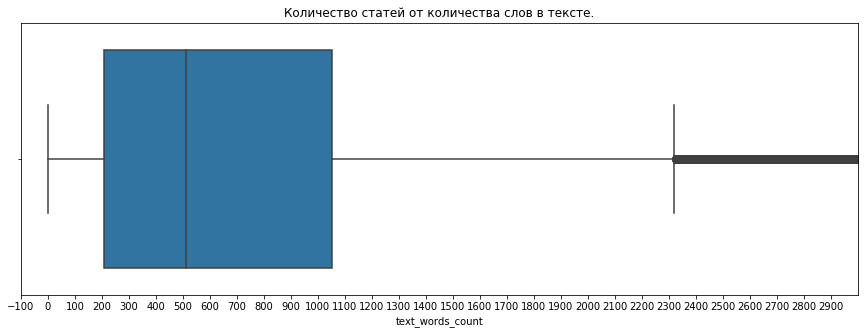

In [195]:
fsize = (15, 5)
fig, ax = plt.subplots(figsize=fsize)
plt.title('Количество статей от количества слов в тексте.')
sns.boxplot(x=df['text_words_count'])
ax.set_xlim(-100,3000);
plt.xticks(range(-100, 3000, 100));

~3/4 статей не превышает 1000 слов.

### Рейтинг

In [60]:
df['rate'].describe()

count    208754.000000
mean         24.369377
std          34.955413
min        -183.000000
25%           6.000000
50%          15.000000
75%          31.000000
max        1448.000000
Name: rate, dtype: float64

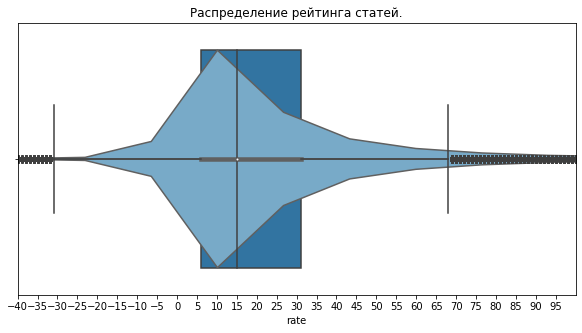

In [202]:
fsize = (10, 5)
fig, ax = plt.subplots(figsize=fsize)
ax.set_xlim(-40,100)
plt.xticks(range(-40, 100, 5))
sns.violinplot(x=df['rate'], palette="Blues")
sns.boxplot(x=df['rate'])
plt.title('Распределение рейтинга статей.');

In [55]:
df_rate_count = df['rate'].value_counts().rename('count').reset_index()
df_rate_count.rename({'index':'rate'}, axis='columns',inplace=True)

In [56]:
df_rate_count.describe()

,rate,count
count,565.000000,565.000000
mean,191.624779,369.476106
std,201.960254,1128.634929
min,-183.000000,1.000000
25%,34.000000,2.000000
50%,175.000000,10.000000
75%,317.000000,92.000000
max,1448.000000,7883.000000


In [140]:
%matplotlib inline

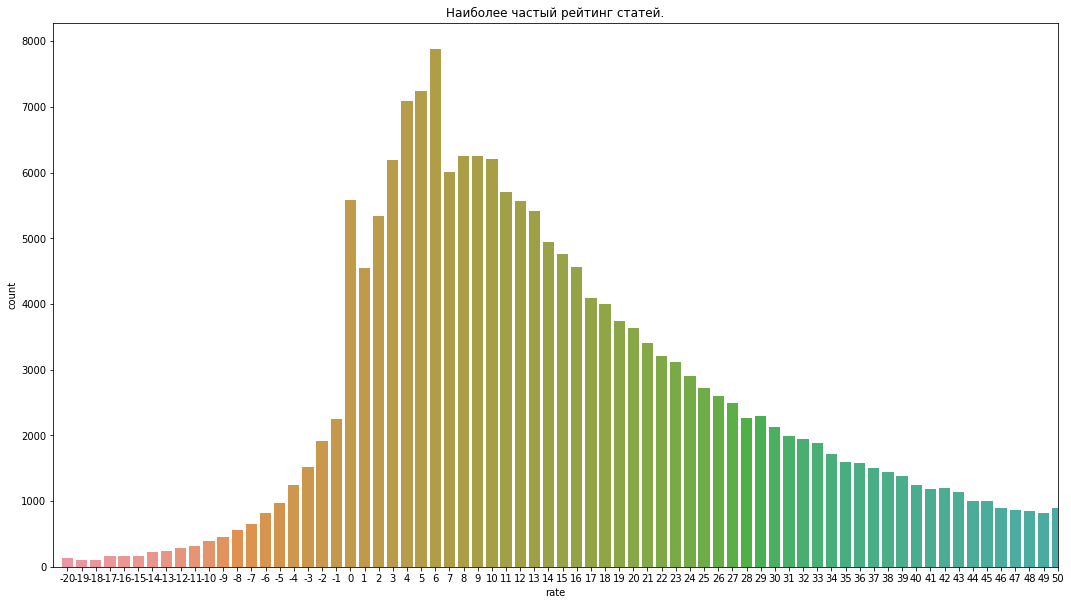

In [203]:
fsize = (18, 10)
fig, ax = plt.subplots(figsize=fsize)
plt.title('Наиболее частый рейтинг статей.');
sns.barplot(y='count',x='rate',data=df_rate_count[df_rate_count['count']>100])
ax.set_xlim(-1,70);

Топ популярных рейтингов лежит в диапазоне от 0-16. Самый часто используемый рейтинг - 6.

Посмотрим на средний рейтинг статей в зависимости от количества слов в заголовке

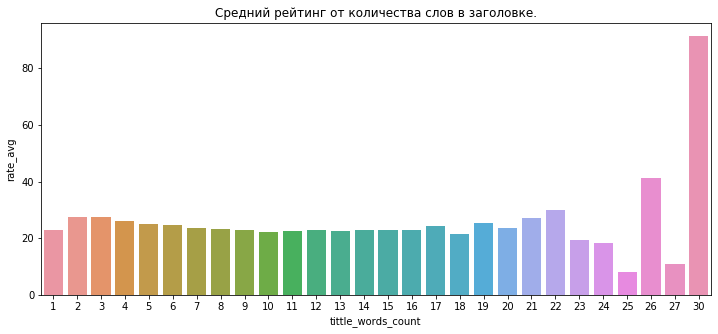

In [114]:
fsize = (12, 5)
fig, ax = plt.subplots(figsize=fsize)    
plt.title('Средний рейтинг от количества слов в заголовке.')
sns.barplot(x='tittle_words_count', y='rate_avg', \
            data=df.groupby('tittle_words_count')['rate'].mean().\
                                    rename('rate_avg').reset_index());

У статей с количеством слов в заголовке от 1-22 средний рейтинг выше 20. А статьи с количеством слов в заголовке 25 и 27 имеют самый низкий средний рейтинг. Максимальный средний рейтинг у статей с количеством слов в заголовке 26 и 30. 

На первый взгляд кажется, что есть корреляция между количеством слов в заголовке и рейтингом. Но выше мы видели, что статей с количеством слов в заголовке от 20 и выше очень мало.

Посмотрю на статьи с количеством слов в заголовке = 30

In [458]:
df[df['tittle_words_count']==30]

,index,date,tittle,text,rate,month,day,hour,weekday,sites_text,...,en_words_text,en_words_text_count,punctuations_text_count,emotions_text_count,text_words_count,text_clwords_count,tittle_words_count,tittle_clwords_count,text_category,rate_category
45953,47737,2010-02-01 21:20:00,"Перепрошивка USB модема ZTE MF627, залоченного...",В продолжение темы 3G-модем в Ubuntu. Пошаго...,224,2,1,21,0,2_exe 2_exe beeline_ru internet_mts tele2_ru i...,...,ubuntu usb zte sim windows ubuntu servik zte h...,379,864,0,2438,380,30,3,4,1
92292,94966,2012-12-08 14:25:00,"Видео: Мама впервые тестирует Windows 8, Ubunt...","В форумах не утихают споры о том, удобна ли...",57,12,8,14,5,,...,windows windows windows windows windows ubuntu...,61,178,0,411,87,30,15,2,1
125621,128329,2015-03-18 10:30:00,Ценопад пришел: серверы в Нидерландах в premiu...,Могли ли в IBM некоторое время назад представ...,-7,3,18,10,2,www_ua,...,ibm evoswitch intel quad core sata http server...,78,174,0,604,93,30,7,3,-1


Их всего 3 штуки! Этого мало, чтобы делать выводы.

Остальных статей, со словами в заголовке от 23 тоже мало, по сравнению с общим количеством.

In [374]:
df[df['tittle_words_count']>22]['tittle_words_count'].value_counts()

24    18
23    16
27    10
26     6
25     6
30     3
Name: tittle_words_count, dtype: int64

Пострим на графики количества статей от количества слов в заголовке

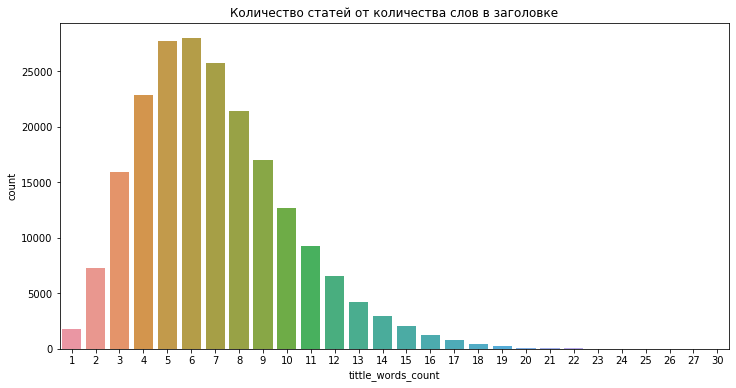

In [103]:
df_twc=df['tittle_words_count'].value_counts(normalize=False).rename('count').reset_index()
df_twc.rename({'index':'tittle_words_count'}, axis='columns',inplace=True)

fsize = (12, 6)
fig, ax = plt.subplots(figsize=fsize)    
plt.title('Количество статей от количества слов в заголовке')
sns.barplot(x='tittle_words_count', y='count', data=df_twc);

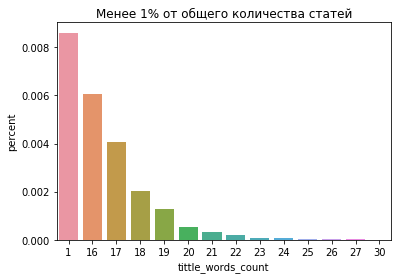

In [217]:
df_twc=df['tittle_words_count'].value_counts(normalize=True).rename('percent').reset_index()
df_twc.rename({'index':'tittle_words_count'}, axis='columns',inplace=True)

plt.title('Менее 1% от общего количества статей')
sns.barplot(x='tittle_words_count', y='percent',data=df_twc[df_twc['percent']<0.01]);


В целом, корреляция рейтинга с количеством слов в заголовке статьи низкая:

In [137]:
df[['rate', 'tittle_words_count']].corr()

,rate,tittle_words_count
rate,1.000000,-0.036737
tittle_words_count,-0.036737,1.000000


Если убрать статьи, у которых количество слов в заголовках менее 1% от общего числа статей, то корреляция возрастет не значительно:

In [133]:
df[~df['rate'].isin(df_twc[df_twc['percent']<0.01]['tittle_words_count'])][['rate', 'tittle_words_count']].corr()

,rate,tittle_words_count
rate,1.000000,-0.041582
tittle_words_count,-0.041582,1.000000


Не линейнай корреляция будет рассмотрена ниже.

Посмотрим на рейтинг статей в зависимости от размера статьи

In [261]:
df_tc_legend = pd.DataFrame({'0':['0'],
              '1':['<'+str(int(df_tc.loc['25%']))],
              '2':['<'+str(int(df_tc.loc['50%']))],
              '3':['<'+str(int(df_tc.loc['75%']))],
              '4':['<'+str(int(df_tc.loc['max']))],
             })

In [337]:
print('Таблица категорий рамера статьи:')
df_tc_legend

Таблица категорий рамера статьи:


,0,1,2,3,4
0,0,<209,<513,<1053,<193861


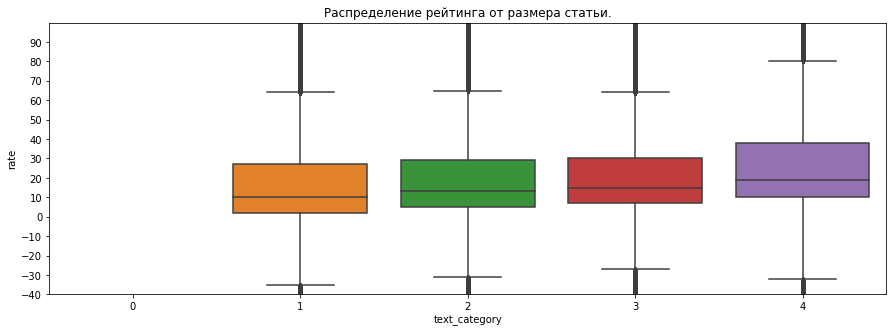

In [327]:
fsize = (15, 5)
fig, ax = plt.subplots(figsize=fsize)
ax.set_ylim(-40,100)
plt.yticks(range(-40, 100, 10))
plt.title('Распределение рейтинга от размера статьи.')
sns.boxplot(y='rate',x='text_category',data=df);

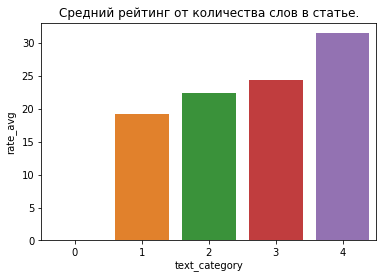

In [224]:
plt.title('Средний рейтинг от количества слов в статье.')
sns.barplot(x='text_category', y='rate_avg', \
            data=df.groupby('text_category')['rate'].mean().\
                                            rename('rate_avg').reset_index());

In [403]:
Тут нужно делать нормализацию

SyntaxError: invalid syntax (<ipython-input-403-217a1a14b039>, line 1)

Видно, что чем больше статья, тем выше рейтинг.

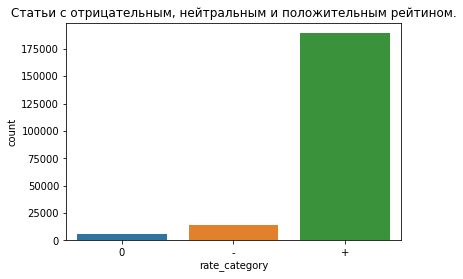

In [344]:
plt.title('Статьи с отрицательным, нейтральным и положительным рейтином.')
sns.countplot(df['rate_category'].map({-1:'-',0:'0',1:'+'}));

Статей с положительным рейтингом значительно больше, чем остальных.

Средний рейтинг категории:

In [346]:
df.groupby('rate_category')['rate'].mean().rename('rate_avg').reset_index()

,rate_category,rate_avg
0,-1,-8.295055
1,0,0.000000
2,1,27.494478


Распределение по категориям рейтинга количества статей в зависимости от категории текста:

In [357]:
dataTC = df.groupby(['text_category'], observed=True)['rate_category'].\
                 value_counts(normalize=True).rename('percent').reset_index().\
                                                     sort_values('text_category')

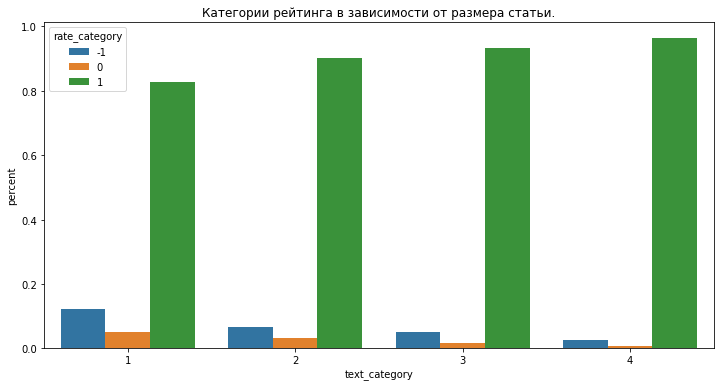

In [358]:
fsize = (12, 6)
fig, ax = plt.subplots(figsize=fsize)  
plt.title('Категории рейтинга в зависимости от размера статьи.')
sns.barplot(x='text_category', y='percent', hue='rate_category',data=dataTC);

Чем больше статья, тем меньше отрицательных и больше положительных. Отрицательных статей всегда больше нейтральных.

In [392]:
def dataTWC(normalize,title='',twc_treshhold=0):
    dataTWC= df[df['tittle_words_count']>=twc_treshhold].groupby(['tittle_words_count'])['rate_category'].\
                                                value_counts(normalize=normalize).rename('count').reset_index()
    fsize = (12, 5)
    fig, ax = plt.subplots(figsize=fsize)
    if twc_treshhold>0:
        title = title + ' >'+str(twc_treshhold-1)
    if normalize:
        title = title + ' (%)'
    plt.title(title)
    sns.barplot(x='tittle_words_count', y='count', hue='rate_category',data=dataTWC);

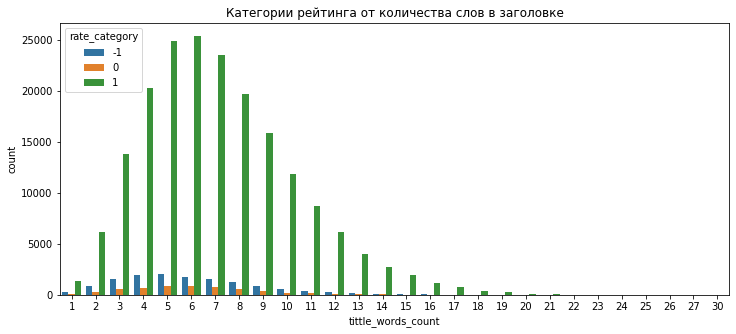

In [378]:
dataTWC(False,'Категории рейтинга от количества слов в заголовке')

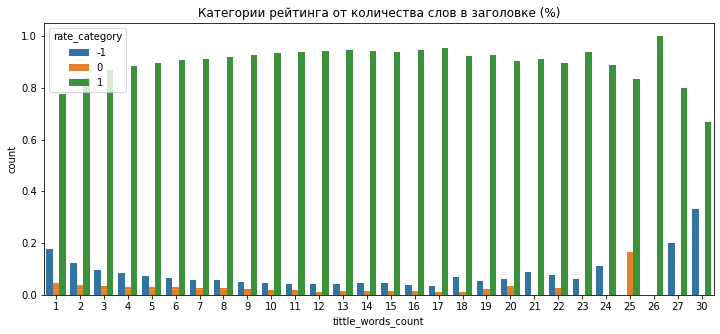

In [379]:
dataTWC(True,'Категории рейтинга от количества слов в заголовке')

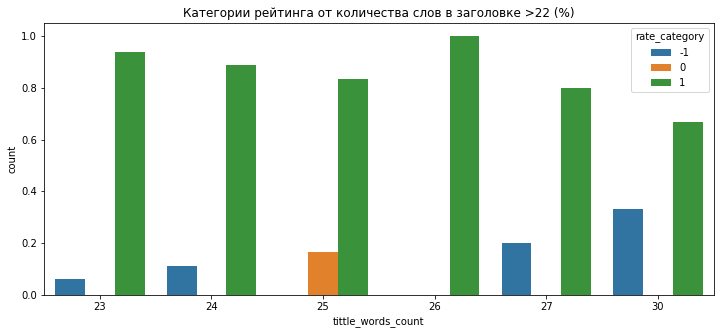

In [393]:
dataTWC(True,'Категории рейтинга от количества слов в заголовке',23)

Для статьей с количеством слов от 23 такое поведение объяснятся малым количеством статей.

Посмотрим на рисунок зависимости количества слов в статье и рейтинга, диффиренцированных по размеру статьи.

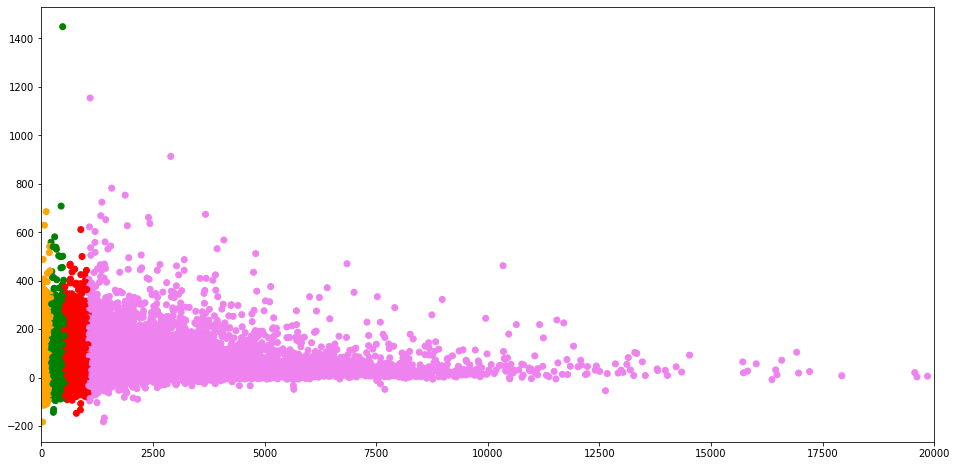

In [404]:
fsize = (16, 8)
fig, ax = plt.subplots(figsize=fsize)
plt.title('')
ax.set_xlim(0,20000)
plt.scatter(df['text_words_count'],df['rate'],\
           color=df['text_category'].map({'0':'blue','1':'orange',\
                                          '2':'green','3':'red','4':'violet'}));


In [ ]:
fsize = (12, 6)
fig, ax = plt.subplots(figsize=fsize)   
plt.scatter(df['tittle_words_count'],df['rate'],\
           color=df['text_category'].map({'0':'blue','1':'orange',\
                                          '2':'green','3':'red','4':'violet'}));

In [396]:
plt.scatter?

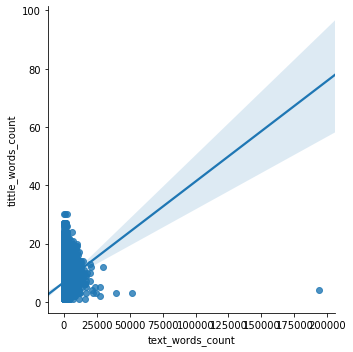

In [213]:
sns.lmplot(x='text_words_count', y='tittle_words_count', data=df);

In [214]:
df[['rate','text_words_count','tittle_words_count']].corr(method='pearson')

,rate,text_words_count,tittle_words_count
rate,1.000000,0.120368,-0.036737
text_words_count,0.120368,1.000000,0.111935
tittle_words_count,-0.036737,0.111935,1.000000


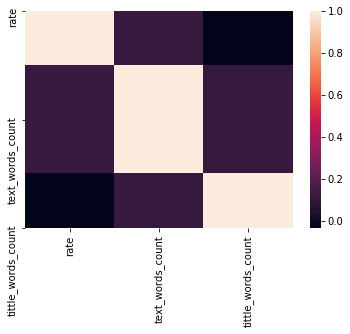

In [215]:
sns.heatmap(df[['rate','text_words_count','tittle_words_count']].corr(method='pearson'));

Какой то явной корреляции не видно. Есть небольшая зависимость длины слов в статье с рейтингом.

### Дата и время

Создам новые признаки, для этого приведем 'date' к формату даты.

<font color='green'>#new_feature</font>

In [ ]:
def AddNewFeature_dates():
    df['date'] = pd.to_datetime(df['date'])
    df['month'] = df['date'].dt.month 
    df['day'] = df['date'].dt.day 
    df['hour'] = df['date'].dt.hour 
    df['weekday'] = df['date'].dt.dayofweek

In [ ]:
AddNewFeature_dates()

In [ ]:
df.info()

In [ ]:
def BarGroupByTwo (col1,col2,normalize:bool):    
    data = df.groupby([col1])[col2].value_counts(normalize=normalize).rename('count').reset_index().sort_values(col1)
    
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)    
    sns.barplot(x=col1, y='count', hue=col2, data=data)
    
    normalize_label=''
    if normalize:
        normalize_label=' (%)'
    plt.title('{} vs {}{}'.format(col2, col1,normalize_label))
    
    labels=["Отрицательный","Нейтральный", "Положительный"]
    h, l = ax.get_legend_handles_labels()
    ax.legend(h, labels)

Посмотрим на зависимость рейтинга от времЕнных параметров

In [ ]:
BarGroupByTwo('month','rate_category',False)

In [ ]:
BarGroupByTwo('month','rate_category',True)

Июль, август, сентябрь и октябрь, месяца, когда меньше всего выходят статьи. В эти месяца количество отрицательных отзывов больше чем в остальные, в процентном соотношении так примерно в 2 раза.

In [ ]:
BarGroupByTwo('weekday','rate_category',False)

In [ ]:
BarGroupByTwo('weekday','rate_category',True)

В субботу и воскресенье (5 и 6) выходит меньше всего статей. При этом, если смотреть в процентном соотношении, то в эти дни больше отрицательных оценок.

In [ ]:
BarGroupByTwo('day','rate_category',False)

In [ ]:
BarGroupByTwo('day','rate_category',True)

Количество статей публикуется волнообразно, видимо это связано с началом и концом недели. Так же в последнии дни месяца заметно снижение в количестве публикаций.

In [ ]:
BarGroupByTwo('hour','rate_category',False)

In [ ]:
BarGroupByTwo('hour','rate_category',True)

Пик публикаций утро и день. С 12-14 часов заметно больше ставят отрицательных оценок.

In [ ]:
df.columns

In [ ]:
sns.heatmap(df[['rate', 'month', 'day', 'hour', 'weekday']].corr(method='pearson'));

Сильной корреляции нет. Небольшая корреляция с рейтингом у дней недели, чисел и часов.

## Подготовка моделей

### LinearRegression, Lasso, Ridge, LassoCV, RidgeCV

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
linear_regression = LinearRegression()
lasso = Lasso(random_state=1,alpha=1)
ridge = Ridge(random_state=1, alpha=1)
lasso_cv = LassoCV(random_state=1)
ridge_cv = RidgeCV()

In [ ]:
#models = [linear_regression,ridge,ridge_cv,lasso,lasso_cv]
models = [linear_regression,ridge,lasso]

In [ ]:
def metricsModel (y_train,y_train_pred,y_test,y_test_pred):
    '''
    расчет метрик
    '''    
    metrics = []
    MSETrain = mean_squared_error(y_train, y_train_pred)
    MSETest = mean_squared_error(y_test, y_test_pred)
    metrics.append(MSETrain)
    metrics.append(MSETest)
    metrics.append(np.sqrt(MSETrain))
    metrics.append(np.sqrt(MSETest))
    metrics.append(r2_score(y_train, y_train_pred))
    metrics.append(r2_score(y_test, y_test_pred))
    return metrics

In [ ]:
def predGroundTruth (predicted_train,predicted_test,y_train,y_test,row=20):
    '''
    сравнение предсказаных рейтингов с реальными на трейне и тесте
    '''  
    predictions_ground_truth_df = pd.DataFrame(list(zip(predicted_train,\
                                                        y_train,predicted_test, y_test)))
    predictions_ground_truth_df.columns = ['PredictionRateTrain', 'RrealRateTrain',\
                                           'PredictionRateTest', 'RrealRateTest']
    print(predictions_ground_truth_df.head(row))

In [ ]:
def CreateTableInfoResult ():
    '''
    сюда буду сохранять результаты обучения моделей для анализа
    '''
    
    modelResults_df=pd.DataFrame(columns=['Comment','Model','MSETrain','MSETest',\
          'sMSETrain','sMSETest','R2Train','R2Test','TrainShape','TestShape'])
    return modelResults_df

In [ ]:
modelResults_df = CreateTableInfoResult()

In [ ]:
import math

In [ ]:
rate_min = df['rate'].min()+1e-8
def LogConvert(rlog,rmin):
    '''
    конвертация рейтинга обратно из нартурального логарифма
    '''
    try:
        rate = math.exp(rlog) + rmin
    except OverflowError:
        rate = float('inf')    
    return rate

In [ ]:
def LogNdArrayConvert(ndarray):
    ndarray_c = np.array([LogConvert(r,rate_min) for r in ndarray])
    return ndarray_c

In [ ]:
def ModelFitPredictAndMettrics(mr_df,comment,model,X_train,y_train,X_test,y_test\
                              ,groundtruth=False,metrics=True,logconvert=False,row=20):
    '''
    обучение модели
    '''
    print(model)    
    model.fit(X_train, y_train)
    predicted_train = model.predict(X_train)
    predicted_test = model.predict(X_test)
    mtxt = ''
    
    if (logconvert):
        predicted_train = LogNdArrayConvert(predicted_train)
        predicted_test = LogNdArrayConvert(predicted_test)
        y_train = LogNdArrayConvert(y_train)
        y_test = LogNdArrayConvert(y_test)
    
    if(groundtruth):
         predGroundTruth(predicted_train,predicted_test,y_train,y_test,row)
    
    mm = metricsModel(y_train,predicted_train,y_test,predicted_test)
    if(metrics):       
           print('\nMSE train:{:.3f}, test: {:.3f}'.format(mm[0],mm[1]))  
           print('sqrt MSE train:{:.3f}, test: {:.3f}'.format(mm[2],mm[3]))
           print('R^2 train: {:.3f}, test: {:.3f}'.format(mm[4],mm[5]))
        
    mr_df = mr_df.append({'Comment':comment,'Model':model,'MSETrain':mm[0],\
                         'MSETest':mm[1],'sMSETrain':mm[2],'sMSETest':mm[3],\
                         'R2Train':mm[4],'R2Test':mm[5],\
                         'TrainShape':X_train.shape,'TestShape':X_test.shape},\
                         ignore_index=True)
    return mr_df

### Векторизация текста

Разбираюсь, что это такое и как работает на основе столбца tittle. 
Посмотрю на модели в лоб, данные как есть, а потом буду улучшать их и добавлять фичи.

In [ ]:
df.isnull().sum()

Т.к. у нас есть временной параметр, и мы хотим прогнозировать будущее, то нужно разбирть выборку на части отсортированную по времени. Учимся на прошлом, прогнозируем будущее.

In [ ]:
def TrainTestSplitByDateTime (coef,df=df,y_col='rate'):
    df.sort_values(by='date',ascending=True,inplace=True)
    df.reset_index(drop=True,inplace=True);
    
    rate_cols = [col for col in df.columns if 'rate' in col]
    X=df.drop(rate_cols,axis=1)
    y=df[y_col]
    train_part_size = int(coef * X.shape[0])
    
    X_train, X_test = X.iloc[:train_part_size, :],X.iloc[train_part_size:, :]
    y_train, y_test = y.iloc[:train_part_size],y.iloc[train_part_size:]
    
    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = TrainTestSplitByDateTime (.8,df,'rate')

In [ ]:
print('Shape train:{},test:{}'.format(X_train.shape,X_test.shape))

### CountVectorizer

Токенизация и векторизация текста

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
columnOne = 'text'

In [ ]:
X_train_curr = X_train[columnOne]
X_test_curr = X_test[columnOne]

In [ ]:
count_vect = CountVectorizer(max_df=1.0, min_df=1,ngram_range=(1, 1)) #токенезированный мешок слов

In [ ]:
X_cvect_train = count_vect.fit_transform(X_train_curr) 
X_cvect_test = count_vect.transform(X_test_curr)

In [ ]:
#обучаемся на мешке слов и кодируем текст в вектора
X_cvect_train.shape

In [ ]:
X_cvect_test.shape

Очень длинный вектор, много слов! Нужно чистить.

In [ ]:
print(count_vect.get_feature_names()) #Мешок слов

In [ ]:
# словарь с идентификаторами расположения слов в словаре
print(count_vect.vocabulary_)

In [ ]:
#закодированный (векторизированный) текст (матрица). Количество вхождений слова в словарь
#X_cvect_train.toarray() 

In [ ]:
# количественное вхождение каждого слова:
matrix_freq = np.asarray(X_cvect_train.sum(axis=0)).ravel()
final_matrix = np.array([np.array(count_vect.get_feature_names()), matrix_freq])

In [ ]:
final_matrix

Цифры и китайские символы, нужно избавляться от них.

### TfidfTransformer

Векторизация с вычисление частот слов (Term Frequency - Inverse Document Frequency)

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

In [ ]:
tfidf_transformer = TfidfTransformer()

In [ ]:
X_tfidf_train = tfidf_transformer.fit_transform(X_cvect_train)
X_tfidf_test = tfidf_transformer.fit_transform(X_cvect_test)

In [ ]:
X_tfidf_train.shape

In [ ]:
X_tfidf_test.shape

In [ ]:
#Tfidf матрица векторов с весами
#X_tfidf_train.toarray()

In [ ]:
tfidf_transformer.idf_

In [ ]:
#топ весов слов
rr = dict(zip(count_vect.get_feature_names(), tfidf_transformer.idf_))

In [ ]:
token_weight = pd.DataFrame.from_dict(rr, orient='index').reset_index()
token_weight.columns=('token','weight')
token_weight = token_weight.sort_values(by='weight', ascending=False)
token_weight.head(10)

In [ ]:
token_weight.tail(10)

Низкий вес у часто встречающихся слов, как раз тут видно, что это предлоги и частицы, от них тоже нужно избавиться в словаре.

In [ ]:
#np.isnan(X_tfidf_train.toarray().any())

### HashingVectorizer

Односторонний хэш слов для преобразования их в целые числа

In [ ]:
from sklearn.feature_extraction.text import HashingVectorizer

In [ ]:
hash_vect = HashingVectorizer(n_features=1000)

In [ ]:
X_hashvect_train = hash_vect.fit_transform(X_train_curr)
X_hashvect_test = hash_vect.transform(X_test_curr)

In [ ]:
# summarize encoded vector
print(X_hashvect_train.shape)
print(X_hashvect_train.toarray())

In [ ]:
print(X_hashvect_test.shape)
print(X_hashvect_test.toarray())

---------------------------------------

При большом количестве данных словарь получается очень большой, очень много мусорных слов. При больших выборках (>40000) результирующая матрица на столько большая, что не хватает памяти. Необходимо обработать текст.

Выполню простую нормализация текста

In [ ]:
import pymorphy2

In [ ]:
def f_tokenizer(s):
    morph = pymorphy2.MorphAnalyzer()    
    if type(s) == str:
        t = s.split(' ')
    else:
        t = s
    f = []
    for j in t:
        m = morph.parse(j.replace('.',''))
        if len(m) != 0:
            wrd = m[0]
            if wrd.tag.POS not in ('NUMR','PREP','CONJ','PRCL','INTJ'):
                f.append(wrd.normal_form)
    return ' '.join(f)

<font color='green'>#new_feature</font>

In [ ]:
def AddNewFeature_norm():
    df[columnOne+'_norm']=df[columnOne].apply(lambda t: f_tokenizer(t))

In [ ]:
AddNewFeature_norm()

In [ ]:
df[[columnOne,columnOne+'_norm']].head(2)

Выделю слова на кирилице и латинице а так же сайты в отдельные словари

Создам еще несколько фичей на основе текста

<font color='green'>#new_feature</font>

In [ ]:
def GetSites (txt):  
    sites = re.findall(r'[\w]+\.{1,1}[^\.\d^\s]\w{1,3}\b',str(txt)) #сайты
    return (' '.join(sites)).replace('.','_'),len(sites)

In [ ]:
def GetEnWords (txt):  
    en_words = re.findall(r'\b[a-z]{3,}\b',re.sub(r'[a-z]{2,}\.+[a-z]*\b','',str(txt))) #слова на латинице от 3х букв    
    return ' '.join(en_words),len(en_words)

In [ ]:
def GetRuWords (txt):  
    ru_words = re.findall(r'\b[а-я]{4,}\b',re.sub(r'[а-я]{2,}\.+[а-я]*\b','',str(txt))) #слова на кириллице от 4х букв
    return ' '.join(ru_words),len(ru_words)

In [ ]:
def GetPunctuationsCount (txt):  
    punctuations  = re.findall(r'[^\w\s]',txt) #Знаки препинания
    return len(punctuations)

In [ ]:
def GetEmotionsCount (txt):  
    emotions  = re.findall(r'[\?]{2,}|[\!]{2,}',txt) #Знаки ??? , !!!
    return len(emotions)

In [ ]:
def AddNewFeature_split_txt(column):
    for index, row in df.iterrows():
        df.loc[index, 'sites_'+column],df.loc[index, 'sites_'+column+'_count'] = GetSites(row[column])
        df.loc[index, 'ru_words_'+column],df.loc[index, 'ru_words_'+column+'_count'] = GetRuWords(row[column+'_norm'])
        df.loc[index, 'en_words_'+column],df.loc[index, 'en_words_'+column+'_count'] = GetEnWords(row[column])
        df.loc[index, 'punctuations_'+column+'_count'] = GetPunctuationsCount(row[column])
        df.loc[index, 'emotions_'+column+'_count'] = GetEmotionsCount(row[column])

In [ ]:
AddNewFeature_split_txt(columnOne)

<font color='green'>#new_feature</font>

Заменю буквенные категории на числовые

In [ ]:
def AddNewFeature_text_category_int():
    df['text_category_int'] = df['text_category'].map({'z':0,'s':1,'m':2,'l':3,'xl':4})

In [ ]:
AddNewFeature_text_category_int()

Посмотрим на графики:

In [ ]:
sns.heatmap(df[['rate', 'sites_text_count', 'ru_words_text_count', 'en_words_text_count',\
                'punctuations_text_count','emotions_text_count','text_category_int',\
               'tittle_words_count','text_words_count']].corr(method='pearson'));

Какой то сильной корреляции фич с рейтингом нет. Некоторые фичи хорошо коррелируют между собой, это и понятно.

Возьму натуральные логарифмы от всех числовых признаков, кроме категориальных:

In [ ]:
df['rate_log'] = np.log(df['rate'] - df['rate'].min()+1e-8)

In [ ]:
df['rate_cube_r'] = df['rate'].apply(lambda r: int(r)**(1/3))

In [ ]:
df['text_words_count_log'] = np.log(df['text_words_count'])
df['tittle_words_count_log'] = np.log(df['tittle_words_count'])

In [ ]:
df['sites_text_count_log'] = np.log(df['sites_text_count'])
df['ru_words_text_count_log'] = np.log(df['ru_words_text_count'])
df['en_words_text_count_log'] = np.log(df['en_words_text_count'])
df['punctuations_text_count_log'] = np.log(df['punctuations_text_count'])
df['emotions_text_count_log'] = np.log(df['emotions_text_count'])

#### Сформирую новые словари и новые матрицы векторов

Формирую 3 словаря - ru,eng,sites, так же в этом случае уйдут все цифры, даты и прочие малоинформативные артифакты

Так же уберу слова, которые очень редко и очень часто встречаются

In [ ]:
n_features=1000 #n_features для HashingVectorizer
cv_max_df=0.99 #Параметры для CountVectorizer default 1.0
cv_min_df=0.005 #Параметры для CountVectorizer default 1
cv_ngram_range=(1, 1) #Параметры для CountVectorizer

In [ ]:
import datetime

Имя файла для сохранения таблицы с метриками в csv:

In [ ]:
fileNameFromExport = 'ex_habr_'+str(rowCountFromCSV)+'_'+str(n_features)+'_'+\
                      str(cv_max_df)+'_'+str(cv_min_df)+'_'+\
                      str(cv_ngram_range)+'_'+f"{datetime.datetime.now():%Y-%m-%d %H-%M-%S}"+'.csv'

In [ ]:
count_vect = CountVectorizer(max_df=cv_max_df, min_df=cv_min_df,\
                             ngram_range=cv_ngram_range)
tfidf_transformer = TfidfTransformer()
hash_vect = HashingVectorizer(n_features=n_features)

In [ ]:
X_train, X_test, y_train, y_test = TrainTestSplitByDateTime (.8,df,'rate')
X_train, X_test, y_train_l, y_test_l = TrainTestSplitByDateTime (.8,df,'rate_log')

In [ ]:
ys = [[y_train,y_test,False],[y_train_l,y_test_l,True]]

In [ ]:
print('Shape train:{},test:{}'.format(X_train.shape,X_test.shape))

In [ ]:
X_train_curr = X_train['ru_words_'+columnOne]
X_test_curr = X_test['ru_words_'+columnOne]

In [ ]:
X_cvect_ru_words_train = count_vect.fit_transform(X_train_curr) 
X_tfidf_ru_words_train = tfidf_transformer.fit_transform(X_cvect_ru_words_train)
X_cvect_ru_words_test = count_vect.transform(X_test_curr) 
X_tfidf_ru_words_test = tfidf_transformer.transform(X_cvect_ru_words_test)
X_hashvect_ru_words_train = hash_vect.fit_transform(X_train_curr)
X_hashvect_ru_words_test = hash_vect.transform(X_test_curr)

rr_ru = dict(zip(count_vect.get_feature_names(), tfidf_transformer.idf_))

In [ ]:
print(X_cvect_ru_words_train.shape,X_tfidf_ru_words_train.shape,X_hashvect_ru_words_train.shape)

In [ ]:
X_train_curr = X_train['en_words_'+columnOne]
X_test_curr = X_test['en_words_'+columnOne]

In [ ]:
X_cvect_en_words_train = count_vect.fit_transform(X_train_curr) 
X_tfidf_en_words_train = tfidf_transformer.fit_transform(X_cvect_en_words_train)
X_cvect_en_words_test = count_vect.transform(X_test_curr) 
X_tfidf_en_words_test = tfidf_transformer.transform(X_cvect_en_words_test)
X_hashvect_en_words_train = hash_vect.fit_transform(X_train_curr)
X_hashvect_en_words_test = hash_vect.transform(X_test_curr)

rr_en = dict(zip(count_vect.get_feature_names(), tfidf_transformer.idf_))

In [ ]:
#Посмотрим на топ веса 2х словарей
def token_weight_df (dic, prefix):    
    token_weight = pd.DataFrame.from_dict(dic, orient='index').reset_index()
    token_weight.columns=(prefix,'weight_'+prefix)
    token_weight = token_weight.sort_values(by='weight_'+prefix, ascending=False)
    return token_weight

rr_2_voc = pd.concat([token_weight_df(rr_ru,'ru').reset_index(drop=True),\
                      token_weight_df(rr_en,'en').reset_index(drop=True),\
                     ],axis=1)

In [ ]:
rr_2_voc.head(10)

In [ ]:
rr_2_voc.tail(10)

Сайты возьму с другими параметрами

In [ ]:
cv_max_df=1.0 #Параметры для CountVectorizer default 1.0
cv_min_df=2 #Параметры для CountVectorizer default 1
cv_ngram_range=(1, 1) #Параметры для CountVectorizer

In [ ]:
count_vect = CountVectorizer(max_df=cv_max_df, min_df=cv_min_df,\
                             ngram_range=cv_ngram_range)

In [ ]:
X_train_curr = X_train['sites_'+columnOne]
X_test_curr = X_test['sites_'+columnOne]

In [ ]:
X_cvect_sites_train = count_vect.fit_transform(X_train_curr) 
X_tfidf_sites_train = tfidf_transformer.fit_transform(X_cvect_sites_train)
X_cvect_sites_test = count_vect.transform(X_test_curr) 
X_tfidf_sites_test = tfidf_transformer.transform(X_cvect_sites_test)
X_hashvect_sites_train = hash_vect.fit_transform(X_train_curr)
X_hashvect_sites_test = hash_vect.transform(X_test_curr)

rr_sites = dict(zip(count_vect.get_feature_names(), tfidf_transformer.idf_))

In [ ]:
print(X_cvect_sites_train.shape,X_tfidf_sites_train.shape,X_hashvect_sites_train.shape)

In [ ]:
#Посмотрим на топ веса
rr_1_voc = token_weight_df(rr_sites,'sites').reset_index(drop=True)

In [ ]:
rr_1_voc.head(10)

In [ ]:
rr_1_voc.tail(10)

Сформирую общую матрицу по 3м словарям

In [ ]:
from scipy.sparse import hstack

In [ ]:
X_cvect_3voc_train = hstack((X_cvect_sites_train, X_cvect_ru_words_train,\
                              X_cvect_en_words_train))

In [ ]:
X_cvect_3voc_test = hstack((X_cvect_sites_test, X_cvect_ru_words_test,\
                              X_cvect_en_words_test))

In [ ]:
X_tfidf_3voc_train = hstack((X_tfidf_sites_train, X_tfidf_ru_words_train,\
                              X_tfidf_en_words_train))

In [ ]:
X_tfidf_3voc_test = hstack((X_tfidf_sites_test, X_tfidf_ru_words_test,\
                              X_tfidf_en_words_test))

In [ ]:
X_hashvect_3voc_train = hstack((X_hashvect_sites_train, X_hashvect_ru_words_train,\
                              X_hashvect_en_words_train))

In [ ]:
X_hashvect_3voc_test = hstack((X_hashvect_sites_test, X_hashvect_ru_words_test,\
                              X_hashvect_en_words_test))

In [ ]:
print(X_cvect_3voc_train.shape)
print(X_cvect_3voc_test.shape)
print(X_tfidf_3voc_train.shape)
print(X_tfidf_3voc_test.shape)
print(X_hashvect_3voc_train.shape)
print(X_hashvect_3voc_test.shape)

Возьму для обучения 5000 строк

In [ ]:
c_row = 5000
X_cvect_3voc_train = X_cvect_3voc_train.tocsr()[:c_row].todense()
X_tfidf_3voc_train = X_tfidf_3voc_train.tocsr()[:c_row].todense()
X_hashvect_3voc_train = X_hashvect_3voc_train.tocsr()[:c_row].todense()

In [ ]:
X_cvect_ru_words_train = X_cvect_ru_words_train.tocsr()[:c_row].todense()
X_tfidf_ru_words_train = X_tfidf_ru_words_train.tocsr()[:c_row].todense()
X_hashvect_ru_words_train = X_hashvect_ru_words_train.tocsr()[:c_row].todense()

In [ ]:
y_train = y_train[0:c_row]
y_train_l = y_train_l[0:c_row]
ys = [[y_train,y_test,False],[y_train_l,y_test_l,True]]

Обучение только на основе столбца 'text'

In [ ]:
def ModelFit_cvect_ru_words_n(m,modelResults_df,X_cvect_ru_words_train,y_train,X_cvect_ru_words_test,y_test,ratelog=False):
    comment=columnOne+ ' + Очистка + Нормализация + только ru_words cvect + rate_log:'+str(ratelog)
    modelResults_df = ModelFitPredictAndMettrics(modelResults_df,comment,m,\
                      X_cvect_ru_words_train,y_train,X_cvect_ru_words_test,y_test,False,False,ratelog)
    return modelResults_df

In [ ]:
def ModelFit_tfidf_ru_words_n(m,modelResults_df,X_tfidf_ru_words_train,y_train,X_tfidf_ru_words_test,y_test,ratelog=False):
    comment=columnOne+ ' + Очистка + Нормализация + только ru_words tfidf + rate_log:'+str(ratelog)
    modelResults_df = ModelFitPredictAndMettrics(modelResults_df,comment,m,\
                      X_tfidf_ru_words_train,y_train,X_tfidf_ru_words_test,y_test,False,False,ratelog)
    return modelResults_df

In [ ]:
def ModelFit_hashvect_ru_words_n(m,modelResults_df,X_hashvect_ru_words_train,y_train,X_hashvect_ru_words_test,y_test,ratelog=False):
    comment=columnOne+ ' + Очистка + Нормализация + только ru_words hashvect + rate_log:'+str(ratelog)
    modelResults_df = ModelFitPredictAndMettrics(modelResults_df,comment,m,\
                      X_hashvect_ru_words_train,y_train,X_hashvect_ru_words_test,y_test,False,False,ratelog)
    return modelResults_df

In [ ]:
def ModelFit_cvect_3voc(m,modelResults_df,X_cvect_3voc_train,y_train,X_cvect_3voc_test,y_test,ratelog=False):
    comment=columnOne+ ' + Очистка + Нормализация + разбиение на 3 словаря cvect + rate_log:'+str(ratelog)
    modelResults_df = ModelFitPredictAndMettrics(modelResults_df,comment,m,\
                      X_cvect_3voc_train,y_train,X_cvect_3voc_test,y_test,False,False,ratelog)
    return modelResults_df

In [ ]:
def ModelFit_tfidf_3voc(m,modelResults_df,X_tfidf_3voc_train,y_train,X_tfidf_3voc_test,y_test,ratelog=False):
    comment=columnOne+ ' + Очистка + Нормализация + разбиение на 3 словаря tfidf + rate_log:'+str(ratelog)
    modelResults_df = ModelFitPredictAndMettrics(modelResults_df,comment,m,\
                      X_tfidf_3voc_train,y_train,X_tfidf_3voc_test,y_test,False,False,ratelog)
    return modelResults_df

In [ ]:
def ModelFit_hashvect_3voc(m,modelResults_df,X_hashvect_3voc_train,y_train,X_hashvecte_3voc_test,y_test,ratelog=False):
    comment=columnOne+ ' + Очистка + Нормализация + разбиение на 3 словаря hashvect + rate_log:'+str(ratelog)
    modelResults_df = ModelFitPredictAndMettrics(modelResults_df,comment,m,\
                      X_hashvect_3voc_train,y_train,X_hashvect_3voc_test,y_test,False,False,ratelog)
    return modelResults_df

In [ ]:
for y  in ys:
    y_train=y[0]
    y_test=y[1]
    ratelogFlag=y[2]
    for m in models:
        modelResults_df = ModelFit_cvect_ru_words_n(m,modelResults_df,X_cvect_ru_words_train,y_train,X_cvect_ru_words_test,y_test,ratelogFlag)
        modelResults_df = ModelFit_tfidf_ru_words_n(m,modelResults_df,X_tfidf_ru_words_train,y_train,X_tfidf_ru_words_test,y_test,ratelogFlag)
        modelResults_df = ModelFit_hashvect_ru_words_n(m,modelResults_df,X_hashvect_ru_words_train,y_train,X_hashvect_ru_words_test,y_test,ratelogFlag)
        modelResults_df = ModelFit_cvect_3voc(m,modelResults_df,X_cvect_3voc_train,y_train,X_cvect_3voc_test,y_test,ratelogFlag)
        modelResults_df = ModelFit_tfidf_3voc(m,modelResults_df,X_tfidf_3voc_train,y_train,X_tfidf_3voc_test,y_test,ratelogFlag)
        modelResults_df = ModelFit_hashvect_3voc(m,modelResults_df,X_hashvect_3voc_train,y_train,X_hashvect_3voc_test,y_test,ratelogFlag)

Обучение только на основе доп. фич

In [ ]:
X_train, X_test, y_train, y_test = TrainTestSplitByDateTime (.8,df,'rate')
X_train, X_test, y_train_l, y_test_l = TrainTestSplitByDateTime (.8,df,'rate_log')

In [ ]:
ys = [[y_train,y_test,False],[y_train_l,y_test_l,True]]

In [ ]:
columnsAddFeatures = ['tittle_words_count', 'text_words_count',\
                    'text_category_int','sites_'+columnOne+'_count', \
            'ru_words_'+columnOne+'_count', 'en_words_'+columnOne+'_count',\
            'punctuations_'+columnOne+'_count','emotions_'+columnOne+'_count']

In [ ]:
X_train_choice_col = X_train[columnsAddFeatures]

In [ ]:
X_test_choice_col = X_test[columnsAddFeatures]

In [ ]:
from scipy import sparse

In [ ]:
X_train_choice_col_m = sparse.csr_matrix(X_train_choice_col)
X_test_choice_col_m = sparse.csr_matrix(X_test_choice_col)

In [ ]:
def ModelFit_only_choice_col(m,modelResults_df,X_train_choice_col_m,y_train,X_test_choice_col_m,y_test,ratelog=False):
    comment=columnOne + ' + только доп.фичи + rate_log:'+str(ratelog)+' + '+', '.join(columnsAddFeatures)
    modelResults_df = ModelFitPredictAndMettrics(modelResults_df,comment,m,\
                      X_train_choice_col_m,y_train,X_test_choice_col_m,y_test,False,False,ratelog)
    return modelResults_df

Так же выполню шкалирование и посмотрю на результат

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()

In [ ]:
# масштабируем данные
X_train_choice_col_m_scaled = scaler.fit_transform(X_train_choice_col)

In [ ]:
X_test_choice_col_m_scaled = scaler.transform(X_test_choice_col)

In [ ]:
def ModelFit_only_choice_col_scaled(m,modelResults_df,X_train_choice_col_m_scaled,y_train,X_test_choice_col_m_scaled,y_test,ratelog=False):
    comment=columnOne + ' + только доп.фичи + масштабирование ss + rate_log:'+str(ratelog)+' + ' +', '.join(columnsAddFeatures)
    modelResults_df = ModelFitPredictAndMettrics(modelResults_df,comment,m,\
                      X_train_choice_col_m_scaled,y_train,X_test_choice_col_m_scaled,y_test,False,False,ratelog)
    return modelResults_df

In [ ]:
for y  in ys:
    y_train=y[0]
    y_test=y[1]
    ratelogFlag=y[2]
    for m in models:
        modelResults_df = ModelFit_only_choice_col(m,modelResults_df,\
                                                      X_train_choice_col_m,y_train,X_test_choice_col_m,y_test,ratelogFlag)
        modelResults_df = ModelFit_only_choice_col_scaled(m,modelResults_df,\
                                        X_train_choice_col_m_scaled,y_train,X_test_choice_col_m_scaled,y_test,ratelogFlag)

Объединю доп. фичи и векторайзеры

In [ ]:
def Create_exp_m (X,vectorizer,dropindex=True):
    if (dropindex):
        exp = pd.concat([X.reset_index(drop=True),\
                           pd.DataFrame(vectorizer.toarray()).reset_index(drop=True)],axis=1)
        exp[columnsAddFeatures] = exp[columnsAddFeatures].astype('float64')
    else:
        exp = pd.concat([X,\
                           pd.DataFrame(vectorizer.toarray()).reset_index(drop=True)],axis=1)   
    exp.columns = range(exp.shape[1])
    exp_m = sparse.csr_matrix(exp)
    return exp_m 

In [ ]:
from scipy.sparse import csr_matrix

In [ ]:
X_train_choice_col = X_train_choice_col[:c_row]

In [ ]:
y_train = y_train[0:c_row]
y_train_l = y_train_l[0:c_row]
ys = [[y_train,y_test,False],[y_train_l,y_test_l,True]]

In [ ]:
X_cvect_exp_m_train = Create_exp_m (X_train_choice_col,csr_matrix(X_cvect_3voc_train))

In [ ]:
X_cvect_exp_m_test = Create_exp_m (X_test_choice_col,X_cvect_3voc_test)

In [ ]:
X_tfidf_exp_m_train = Create_exp_m (X_train_choice_col,csr_matrix(X_tfidf_3voc_train))

In [ ]:
X_tfidf_exp_m_test = Create_exp_m (X_test_choice_col,X_tfidf_3voc_test)

In [ ]:
X_hashvect_exp_m_train = Create_exp_m (X_train_choice_col,csr_matrix(X_hashvect_3voc_train))

In [ ]:
X_hashvect_exp_m_test = Create_exp_m (X_test_choice_col,X_hashvect_3voc_test)

In [ ]:
print(X_cvect_exp_m_train.shape)
print(X_tfidf_exp_m_train.shape)
print(X_hashvect_exp_m_train.shape)

In [ ]:
def ModelFit_cvect_exp_m(m,modelResults_df,X_cvect_exp_m_train,y_train,X_cvect_exp_m_test,y_test,ratelog=False):
    comment=columnOne+ ' + Очистка + Нормализация + разбиение на 3 словаря cvect + rate_log:'+str(ratelog)+' + доп.фичи + '+ ', '.join(columnsAddFeatures)
    modelResults_df = ModelFitPredictAndMettrics(modelResults_df,comment,m,\
                      X_cvect_exp_m_train,y_train,X_cvect_exp_m_test,y_test,False,False,ratelog)
    return modelResults_df

In [ ]:
def ModelFit_tfidf_exp_m(m,modelResults_df,X_tfidf_exp_m_train,y_train,X_tfidf_exp_m_test,y_test,ratelog=False):
    comment=columnOne+ ' + Очистка + Нормализация + разбиение на 3 словаря tfidf + rate_log:'+str(ratelog)+' + доп.фичи + '+ ', '.join(columnsAddFeatures)
    modelResults_df = ModelFitPredictAndMettrics(modelResults_df,comment,m,\
                      X_tfidf_exp_m_train,y_train,X_tfidf_exp_m_test,y_test,False,False,ratelog)
    return modelResults_df

In [ ]:
def ModelFit_hashvect_exp_m(m,modelResults_df,X_hashvect_exp_m_train,y_train,X_hashvect_exp_m_test,y_test,ratelog=False):
    comment=columnOne+ ' + Очистка + Нормализация + разбиение на 3 словаря hashvect + rate_log:'+str(ratelog)+' + доп.фичи + '+ ', '.join(columnsAddFeatures)
    modelResults_df = ModelFitPredictAndMettrics(modelResults_df,comment,m,\
                      X_hashvect_exp_m_train,y_train,X_hashvect_exp_m_test,y_test,False,False,ratelog)
    return modelResults_df

In [ ]:
for y  in ys:
    y_train=y[0]
    y_test=y[1]
    ratelogFlag=y[2]
    for m in models:
        modelResults_df = ModelFit_cvect_exp_m(m,modelResults_df,X_cvect_exp_m_train,y_train,X_cvect_exp_m_test,y_test,ratelogFlag)
        modelResults_df = ModelFit_tfidf_exp_m(m,modelResults_df,X_tfidf_exp_m_train,y_train,X_tfidf_exp_m_test,y_test,ratelogFlag)
        modelResults_df = ModelFit_hashvect_exp_m(m,modelResults_df,X_hashvect_exp_m_train,y_train,X_hashvect_exp_m_test,y_test,ratelogFlag)    

Тоже самое, но с масштабированными данными

In [ ]:
X_train_choice_col_m_scaled = X_train_choice_col_m_scaled[:c_row]

In [ ]:
X_cvect_exp_m_scaled_train = Create_exp_m (pd.DataFrame(X_train_choice_col_m_scaled),csr_matrix(X_cvect_3voc_train),False)
X_cvect_exp_m_scaled_test = Create_exp_m (pd.DataFrame(X_test_choice_col_m_scaled),csr_matrix(X_cvect_3voc_test),False)
X_tfidf_exp_m_scaled_train = Create_exp_m (pd.DataFrame(X_train_choice_col_m_scaled),csr_matrix(X_tfidf_3voc_train),False)
X_tfidf_exp_m_scaled_test = Create_exp_m (pd.DataFrame(X_test_choice_col_m_scaled),csr_matrix(X_tfidf_3voc_test),False)
X_hashvect_exp_m_scaled_train = Create_exp_m (pd.DataFrame(X_train_choice_col_m_scaled),csr_matrix(X_hashvect_3voc_train),False)
X_hashvect_exp_m_scaled_test = Create_exp_m (pd.DataFrame(X_test_choice_col_m_scaled),csr_matrix(X_hashvect_3voc_test),False)

In [ ]:
def ModelFit_cvect_exp_m_scaled(m,modelResults_df,X_cvect_exp_m_scaled_train,y_train,X_cvect_exp_m_scaled_test,y_test,ratelog=False):
    comment=columnOne+ ' + Очистка + Нормализация + разбиение на 3 словаря cvect + rate_log:'+str(ratelog)+' + доп.фичи + масштабирование ss + '+ ', '.join(columnsAddFeatures)
    modelResults_df = ModelFitPredictAndMettrics(modelResults_df,comment,m,\
                      X_cvect_exp_m_scaled_train,y_train,X_cvect_exp_m_scaled_test,y_test,False,False,ratelog)
    return modelResults_df

In [ ]:
def ModelFit_tfidf_exp_m_scaled(m,modelResults_df,X_tfidf_exp_m_scaled_train,y_train,X_tfidf_exp_m_scaled_test,y_test,ratelog=False):
    comment=columnOne+ ' + Очистка + Нормализация + разбиение на 3 словаря tfidf + rate_log:'+str(ratelog)+' + доп.фичи + масштабирование ss + '+ ', '.join(columnsAddFeatures)
    modelResults_df = ModelFitPredictAndMettrics(modelResults_df,comment,m,\
                      X_tfidf_exp_m_scaled_train,y_train,X_tfidf_exp_m_scaled_test,y_test,False,False,ratelog)
    return modelResults_df

In [ ]:
def ModelFit_hashvect_exp_m_scaled(m,modelResults_df,X_hashvect_exp_m_scaled_train,y_train,X_hashvect_exp_m_scaled_test,y_test,ratelog=False):
    comment=columnOne+ ' + Очистка + Нормализация + разбиение на 3 словаря hashvect + rate_log:'+str(ratelog)+' + доп.фичи + масштабирование ss + '+ ', '.join(columnsAddFeatures)
    modelResults_df = ModelFitPredictAndMettrics(modelResults_df,comment,m,\
                      X_hashvect_exp_m_scaled_train,y_train,X_hashvect_exp_m_scaled_test,y_test,False,False,ratelog)
    return modelResults_df

In [ ]:
for y  in ys:
    y_train=y[0]
    y_test=y[1]
    ratelogFlag=y[2]
    for m in models:
        modelResults_df = ModelFit_cvect_exp_m_scaled(m,modelResults_df,X_cvect_exp_m_scaled_train,y_train,X_cvect_exp_m_scaled_test,y_test,ratelogFlag)
        modelResults_df = ModelFit_tfidf_exp_m_scaled(m,modelResults_df,X_tfidf_exp_m_scaled_train,y_train,X_tfidf_exp_m_scaled_test,y_test,ratelogFlag)
        modelResults_df = ModelFit_hashvect_exp_m_scaled(m,modelResults_df,X_hashvect_exp_m_scaled_train,y_train,X_hashvect_exp_m_scaled_test,y_test,ratelogFlag)

Чем отличаются словари теста и трейна? Почему на тесте такая низкая точность?

Сформирую словарь для теста

In [ ]:
count_vect_test = CountVectorizer(max_df=cv_max_df, min_df=cv_min_df,\
                             ngram_range=cv_ngram_range)
tfidf_transformer_test = TfidfTransformer()

In [ ]:
X_test_curr = X_test['ru_words_'+columnOne]

In [ ]:
X_cvect_ru_words_test2 =count_vect_test.fit_transform(X_test_curr) 
X_tfidf_ru_words_test2 =tfidf_transformer_test.fit_transform\
                        (X_cvect_ru_words_test2)

In [ ]:
rr_ru_test = dict(zip(count_vect_test.get_feature_names(),\
                      tfidf_transformer_test.idf_))

In [ ]:
rr_ru_test_df = token_weight_df(rr_ru_test,'ru')
rr_ru_train_df = token_weight_df(rr_ru,'ru')

In [ ]:
rr_ru_test_df.head(10)

In [ ]:
rr_ru_train_df.head(10)

Посмотрим вообще сколько слов есть в словаре трейна из тестовой выборки и какие у них веса

In [ ]:
len(set(rr_ru_train_df['ru']))

In [ ]:
len(set(rr_ru_test_df['ru']))

In [ ]:
rr_ru_testIntrain = list(set(rr_ru_train_df['ru']) - set(rr_ru_test_df['ru']))

In [ ]:
len(rr_ru_testIntrain)

Практически все слова теста содержатся в словаре трейна. Значит модель плохо обучилась. Нет взаимосвязи между словами и рейтингом.

Попробую сделать отдельные словари для отрицательных, нулевых и положительных статей

In [ ]:
count_vect_rate = CountVectorizer(max_df=cv_max_df, min_df=cv_min_df,\
                             ngram_range=cv_ngram_range)
tfidf_transformer_rate = TfidfTransformer()

In [ ]:
df.columns

In [ ]:
X_test_curr_0 = df[df['rate_category'] == 0]['ru_words_'+columnOne]

In [ ]:
X_test_curr_gt0 = df[df['rate_category'] > 0]['ru_words_'+columnOne]

In [ ]:
X_test_curr_lt0 = df[df['rate_category'] < 0]['ru_words_'+columnOne]

In [ ]:
def voc_for_rate (words):    
    X_cvect_ru_words_rate =count_vect_rate.fit_transform(words) 
    X_tfidf_ru_words_rate =tfidf_transformer_rate.fit_transform(X_cvect_ru_words_rate)
    rr_ru_rate = dict(zip(count_vect_rate.get_feature_names(),tfidf_transformer_rate.idf_))
    return token_weight_df(rr_ru_rate,'ru')

In [ ]:
rr_ru_rate_0 =  voc_for_rate(X_test_curr_0)
rr_ru_rate_gt0 =  voc_for_rate(X_test_curr_gt0)
rr_ru_rate_lt0 =  voc_for_rate(X_test_curr_lt0)

In [ ]:
print('len_0={0}; len_gt0={1}; len_lt0={2}'.format(len(rr_ru_rate_0['ru']),len(rr_ru_rate_gt0['ru']),len(rr_ru_rate_lt0['ru'])))

Сколько слов из статей с отрицательным рейтингом содержется в статьях с положительным:

In [ ]:
len(rr_ru_rate_gt0['ru']) - len(list(set(rr_ru_rate_gt0['ru']) - set(rr_ru_rate_lt0['ru'])))

In [ ]:
rr_ru_rate_gt0.head()

In [ ]:
rr_ru_rate_lt0.head()

Практически все слова из статей с отрицательным рейтингом содержатся в статьях с положительным.
Нужно проанализировать тексты этих статей и подмумать над передачей модели смысловых нагрузок.

### word2vec

In [ ]:
from gensim.models import word2vec

In [ ]:
df['ru_words_text_w2v'] = df['ru_words_text'].\
                                apply(lambda t: t.split(' '))

In [ ]:
w2v = word2vec.Word2Vec(df['ru_words_text_w2v'], size=300, window=5, workers=2)
w2v_dict = dict(zip(w2v.wv.index2word, w2v.wv.syn0))

In [ ]:
w2v.wv.most_similar(positive=['гугл'])

In [ ]:
class mean_vectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(w2v_dict.values())))

    def fit(self, X):
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [ ]:
data_mean = mean_vectorizer(w2v).fit(df['ru_words_text_w2v']).\
                                    transform(df['ru_words_text_w2v'])
data_mean.shape

In [ ]:
def TrainTestSplitForW2V (coef,X,y):
    
    train_part_size = int(coef * X.shape[0])
    
    X_train, X_test = X[:train_part_size, :],X[train_part_size:, :]
    y_train, y_test = y[:train_part_size],   y[train_part_size:]
    
    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = TrainTestSplitForW2V(.8,data_mean,df['rate'])
X_train, X_test, y_train_l, y_test_l = TrainTestSplitForW2V(.8,data_mean,df['rate_log'])

In [ ]:
ys = [[y_train,y_test,False],[y_train_l,y_test_l,True]]

In [ ]:
df['ru_words_text_w2v'].shape

In [ ]:
def ModelFit_ru_words_w2v(m,modelResults_df,X_train,y_train,X_test,y_test,ratelog=False):
    comment=columnOne+ '+ ru_words + w2v + rate_log:'+str(ratelog)
    modelResults_df = ModelFitPredictAndMettrics(modelResults_df,comment,m,\
                      X_train,y_train,X_test,y_test,False,False,ratelog)
    return modelResults_df

In [ ]:
for y  in ys:
    y_train=y[0]
    y_test=y[1]
    ratelogFlag=y[2]
    for m in models:
        modelResults_df = ModelFit_ru_words_w2v(m,modelResults_df,X_train,y_train,X_test,y_test,ratelogFlag) 

In [ ]:
pd.set_option('display.max_colwidth', -1)

In [ ]:
modelResults_df.sort_values(by='sMSETest')

In [ ]:
modelResults_df.to_csv(fileNameFromExport, sep=';',index=False,encoding="windows-1251")

_________________________________________

Что дальше?
1. Понять почему низкая оценка на тесте и повысить качество предикшена
2. Попробовать n-граммы
3. Разобраться с Pipeline и GridSearchCV, переписать с помощью них обучение и проработать разные гиперпараметры моделей
4. По словарям, попробовать разные словари на положительные и отрицательные статьи, попробовать их объеденить взяв определенные части, понять чем они отличаются, какие уникальные вещи.
5. kNN для построения мета-признаков
6. Попробовать отдельные словари например на слова относящиеся к "apple", "it", "деньгам" и др.